<a href="https://colab.research.google.com/github/daniela-estevez/ProyectoIntegrador/blob/main/Avance5_13Equipo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Avance 5. Modelo final

## Equipo 13

## Alejandro García Hernández A01793812
## Daniela Estevez Rodriguez A01793723
## Carlos Alberto López Álvarez A01168193

## Objetivos

En esta etapa el objetivo es construir múltiples modelos con lafinalidad de explorar y evaluar cuál de ellos proporciona el mejor rendimiento para resolver el problema que nos fue asignado. El ejercicio se centra en la elección de los modelos, su entrenamiento y configuración de hiperparámetros para mejorar el desempeño.

## 0. Librerías

In [326]:
import warnings
warnings.filterwarnings("ignore")

In [327]:
# Librerías a utilizar para el pre procesamiento.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import LabelEncoder

In [328]:
# Librerías para la sección de modelos supervisados y ensambles
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV, cross_val_predict
from sklearn.metrics import confusion_matrix,f1_score, accuracy_score, classification_report, recall_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import display
from xgboost import plot_importance
from sklearn.preprocessing import LabelEncoder
from sklearn.dummy import DummyClassifier

from sklearn.ensemble import BaggingClassifier

In [329]:
# El siguiente bloque se agregó para poder leer los archivos drive
#from google.colab import drive
#drive.mount('/content/drive')
#%cd /content/drive/MyDrive/Colab Notebooks/Proyecto Integrador

## 1. Preparación de datos

Se aplica el pre procesamiento de los datos que se ha trabajado en semanas anteriores

In [330]:
data = pd.read_csv("base.csv",sep=",", encoding="latin1")
df= data.copy()

In [331]:
# Eliminamos entonces estas características
df = df.drop(["Nombre","residencia","fecha_nacimiento","fecha_1er_visita","FECHA_INICIO_ACTUAL_EPISODIO"], axis=1)
df = df.dropna(axis=1, how='all')

In [332]:
# Calculamos el porcentaje de valores nulos en cada columna
null_percentage = (df.isnull().sum() / len(df)) * 100

# Con el sguiente código, se crea un DataFrame con los porcentajes de valores nulos
null_df = pd.DataFrame({'Columna': null_percentage.index, 'Porcentaje_Null': null_percentage.values})

# Filtramos el DataFrame para mantener solo las columnas donde el porcentaje de valores nulos sea menor al 40%
columnas_a_mantener = null_df[null_df['Porcentaje_Null'] < 40]['Columna']

# Filtramos el DataFrame original para mantener solo las columnas que queremos conservar
df = df[columnas_a_mantener]

In [333]:
#Primero obtenemos las variables que reportan un solo valor y mostramos sus nombres
unique_counts = df.nunique()
columnas_a_eliminar = unique_counts[unique_counts == 1].index
columnas_a_eliminar
df = df.drop(columns=columnas_a_eliminar)

In [334]:
binary_columns = []
for column in df.columns:
    unique_values = df[column].unique()
    if len(unique_values) == 2 and all(value in [0, 1] for value in unique_values):
        binary_columns.append(column)

# Número de columnas con solamente 0's o 1's
print("Numero de columnas binarias encontradas:", len(binary_columns))

Numero de columnas binarias encontradas: 28


In [335]:
# Actualizamos el tipo de las columnas binarias a booleano usando astype()
for column in binary_columns:
    df[column] = df[column].astype(bool)

In [336]:
# Lista de variables que son en realidad categóricas
cat_cols=["SEXO","CONDICION_ACTUAL","ESTADO_civil","RELIGION","PROVEEDOR_FAMILIAR","OCUPACIoN_JEFE_FAMILIA","ESCOLARIDAD__JEFE_FAMILIA",
         "ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","CODIGO_DX.1","TRASTORNO_MAYOR_DIAGNOSTICO",
         "Riesgo_suicidio","Sintomas_ansiosos"]

# Actualizamos el tipo de las columnas categoricas usando astype()
for column in cat_cols:
    df[column] = df[column].astype("category")

In [337]:
# Actualizamos el tipo de la columna MENARCA a uno numérico usando astype()
df["MENARCA"] = df["MENARCA"].astype("float64")

In [338]:
# Sustituir los valores de MENARCA donde SEXO es "M"
df.loc[df['SEXO'] == 'M', 'MENARCA'] = -1

# Imputar la moda a las variables numéricas
for columna in df.select_dtypes(include='number').columns:
    df[columna] = df[columna].fillna(df[columna].median())

# Imputar la moda a las variables booleanas
for columna in df.select_dtypes(include='bool').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

# Imputar la moda a las variables alfanuméricas
for columna in df.select_dtypes(include='category').columns:
    moda = df[columna].mode()[0]  # Calcular la moda
    df[columna] = df[columna].fillna(moda)

In [339]:
# Lista de variables que son en realidad enteros
enteros_cols=["EDAD_1era_visita","EDAD_INICIO_1er_EPISODIO","AnioS_ESTUDIO_PACIENTE","MENARCA","INICIO_VIDA_SEXUAL_ACTIVA","MADRS_TOTAL","CGI-S.1"]

# Actualizamos el tipo de las columnas de enteros usando astype()
for column in enteros_cols:
    df[column] = df[column].astype("int64")

In [340]:
# Eliminamos estas características
df = df.drop(["EPISODIO_MAYOR_total_vida","SUICIDALIDAD_ACTUAL","SUICIDALIDAD_INTENTO_total_vida",
              "B1b_INTENCION_DE_MORIR_EN_ACCIDENTE","B5_PENSO_METODO_SUICIDARSE","B8_PENSO_FECHA_SUICIDIO",
              "B10_INTENCION_SUICIDIO","B18_INTENTO_SUICIDARSE","B2_NECESIDAD_DE_ESTAR_MUERTO","TRASTORNO_MAYOR_PASADO"],
             axis=1)

In [341]:
# Eliminamos estas características
df = df.drop(["CODIGO_DX.1","Puntaje_experto"],
             axis=1)

In [342]:
# Reemplazar el valor 1955 por la mediana
df['EDAD_INICIO_1er_EPISODIO'] = df['EDAD_INICIO_1er_EPISODIO'].replace(1955, df['EDAD_INICIO_1er_EPISODIO'].median())

# Reemplazar el valor 1 por la mediana
df['INICIO_VIDA_SEXUAL_ACTIVA'] = df['INICIO_VIDA_SEXUAL_ACTIVA'].replace(1, df['INICIO_VIDA_SEXUAL_ACTIVA'].median())

In [343]:
# Realizamos una copia del df para realizar una trasnformación
df_T=df.copy()

**Winsonorización:** Reemplaza los valores atípicos con valores en el percentil p-ésimo o (1 - p)-ésimo para reducir su impacto sin eliminarlos.

In [344]:
# Transformamos las variables usando Winsonorización
df_T['INICIO_VIDA_SEXUAL_ACTIVA_W'] = winsorize(df_T['INICIO_VIDA_SEXUAL_ACTIVA'], limits=(0.05, 0.05))
df_T['DURACION_EPISODIO_MAYOR_ACTUAL_W'] = winsorize(df_T['DURACION_EPISODIO_MAYOR_ACTUAL'], limits=(0.05, 0.05))

In [345]:
# Eliminamos estas características originales
df_T = df_T.drop(["INICIO_VIDA_SEXUAL_ACTIVA","DURACION_EPISODIO_MAYOR_ACTUAL"],
             axis=1)

In [346]:
# Hacemos listas de las variables ordinales
cat_orginales= ['ESCOLARIDAD__JEFE_FAMILIA', 'ESCOLARIDAD_MAXIMA_PX', 'DX_PRIMARIO','TRASTORNO_MAYOR_DIAGNOSTICO',
                'Riesgo_suicidio','Sintomas_ansiosos']

In [347]:
# Creamos una copia del dataframe
df_TC=df_T.copy()

In [348]:
# Crear el encoder ordinal
encoder_1 = OrdinalEncoder(categories=[["Menos de 6 años", "Primaria", "Secundaria", "Preparatoria",
                                     "Estudios universitarios no terminados", "Licenciatura", "Posgrado"]], dtype=int)
encoder_2 = OrdinalEncoder(categories=[["Distimia","Trastorno depresivo episodio único ",
                                        "Trastorno depresivo mayor recidivante"]], dtype=int)
encoder_3 = OrdinalEncoder(categories=[["0","TRASTORNO DEPRESIVO MAYOR","TRASTORNO DEPRESIVO MAYOR EPISODIO UNICO O PRIMER EPISODIO",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE O RECIDIVANTE",
                                        "TRASTORNO DEPRESIVO MAYOR RECURRENTE RESISTENTE O SEVERO"]], dtype=int)
encoder_4 = OrdinalEncoder(categories=[["Leve","Moderado","Alto"]], dtype=int)
encoder_5 = OrdinalEncoder(categories=[["Leve","Moderado-Grave"]], dtype=int)
encoder_6 = OrdinalEncoder(categories=[["Primera aparición sin antecedente","Indistinguible del pasado",
                                        "Recurrencia condición previa",
                                        "Significativamente diferente de condición previa",
                                        "Exageración de trastorno crónico"]], dtype=int)

# Ajustar y transformar los datos
df_TC['ESCOLARIDAD__JEFE_FAMILIA_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD__JEFE_FAMILIA']])
df_TC['ESCOLARIDAD_MAXIMA_PX_encoded'] = encoder_1.fit_transform(df_TC[['ESCOLARIDAD_MAXIMA_PX']])
df_TC['DX_PRIMARIO_encoded'] = encoder_2.fit_transform(df_TC[['DX_PRIMARIO']])
df_TC['TRASTORNO_MAYOR_DIAGNOSTICO_encoded'] = encoder_3.fit_transform(df_TC[['TRASTORNO_MAYOR_DIAGNOSTICO']])
df_TC['Riesgo_suicidio_encoded'] = encoder_4.fit_transform(df_TC[['Riesgo_suicidio']])
df_TC['Sintomas_ansiosos_encoded'] = encoder_5.fit_transform(df_TC[['Sintomas_ansiosos']])
df_TC['CONDICION_ACTUAL_encoded'] = encoder_6.fit_transform(df_TC[['CONDICION_ACTUAL']])

In [349]:
# Eliminamos estas características originales
df_TC = df_TC.drop(["ESCOLARIDAD__JEFE_FAMILIA","ESCOLARIDAD_MAXIMA_PX","DX_PRIMARIO","TRASTORNO_MAYOR_DIAGNOSTICO",
                "Riesgo_suicidio","Sintomas_ansiosos","CONDICION_ACTUAL"],
             axis=1)

In [350]:
# Hacemos listas de las variables no ordinales
cat_no_orginales= ['SEXO', 'ESTADO_civil', 'RELIGION','PROVEEDOR_FAMILIAR', 'OCUPACIoN_JEFE_FAMILIA']

In [351]:
# Creamos una copia del ultimo dataframe
df_TCL=df_TC.copy()

In [352]:
# Inicializar el LabelEncoder
encoder = LabelEncoder()

# Iterar sobre las columnas y aplicar el LabelEncoder
for col in cat_no_orginales:
    df_TCL[col] = encoder.fit_transform(df_TCL[col])

In [353]:
# Creamos una copia del ultimo dataframe
df_TC_encoded=df_TC.copy()

In [354]:
# Aplicar Get_dummies asegurando de eliminar la primera categoría
df_TC_encoded = pd.get_dummies(df_TC_encoded, columns=cat_no_orginales, drop_first=True)

## **2 Ensambles**

### **2.1 Baseline**

In [355]:
# Generamos la base con las características y la variable de salida
X1 = df_TC_encoded.drop(columns=['Sintomas_ansiosos_encoded'])
Y1 = df_TC_encoded['Sintomas_ansiosos_encoded']
Xtv1, Xtest1, ytv1, ytest1 = train_test_split(X1, Y1, train_size = 0.9, random_state = 0)

Generamos un modelo Dummy que predice siempre la clase positiva. Esto para tener una referencia con la cual comparar el resto de modelos.

In [377]:
# Creamos un modelo
dummy_clf = DummyClassifier(strategy='most_frequent', random_state= 0)

# Se ajusta el modelo a los datos de entrenamiento
dummy_clf.fit(Xtv1, ytv1)
preds_dum_tv = dummy_clf.predict_proba(Xtv1)


### **2.2 Stacking**

Con esta técnica de ensamble probaremos regresión logística como meta-modelo y como características de entrada usaremos diferentes combinaciones de los mejores modelos supervisados que encontramos en la etapa anterior.

#### 2.2.1 Regresión logística y SVM

In [357]:
# Definimos el modelo
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# Se ajusta el modelo
reg.fit(Xtv1, ytv1)

preds_reg_tv = reg.predict_proba(Xtv1)[:, 1]
preds_reg_test = reg.predict_proba(Xtest1)[:, 1]

In [358]:
# Definimos el modelo
svm = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# Se ajusta el modelo
svm.fit(Xtv1, ytv1)

preds_svm_tv = svm.predict_proba(Xtv1)[:, 1]
preds_svm_test = svm.predict_proba(Xtest1)[:, 1]


In [359]:
# Creamos el conjunto de datos para el ensamble
stacked_tv = np.column_stack((preds_reg_tv, preds_svm_tv))
stacked_test = np.column_stack((preds_reg_test, preds_svm_test))

In [360]:
ensamble1 = LogisticRegression()
ensamble1.fit(stacked_tv, ytv1)


# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento
ytv1_pred_dum = cross_val_predict(dummy_clf, Xtv1, ytv1, cv=5)
recall_tv_dum = '' # No se calcula ya que recall evalua la tasa de verdaderos positivos y nuestro Dummy genera un 100% de positivos
recall_tv_macro_dum = ''
f1_tv_dum = f1_score(ytv1, ytv1_pred_dum, average='binary')


ytv1_pred_reg = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv_reg = recall_score(ytv1, ytv1_pred_reg, average='binary')
recall_tv_macro_reg = recall_score(ytv1, ytv1_pred_reg, average='macro')
f1_tv_reg = f1_score(ytv1, ytv1_pred_reg, average='binary')


ytv1_pred_svm = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv_svm = recall_score(ytv1, ytv1_pred_svm, average='binary')
recall_tv_macro_svm = recall_score(ytv1, ytv1_pred_svm, average='macro')
f1_tv_svm = f1_score(ytv1, ytv1_pred_svm, average='binary')


ytv1_pred_ensamble1 = ensamble1.predict(stacked_tv)
recall_tv_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='binary')
recall_tv_macro_ensamble1 = recall_score(ytv1, ytv1_pred_ensamble1, average='macro')
f1_tv_ensamble1 = f1_score(ytv1, ytv1_pred_ensamble1, average='binary')

cuadro1 = {
    'Modelo': ['Modelo Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_tv_dum, recall_tv_reg, recall_tv_svm, recall_tv_ensamble1],
    'Recall Macro': [recall_tv_macro_dum, recall_tv_macro_reg, recall_tv_macro_svm, recall_tv_macro_ensamble1],
    'F1 Score': [f1_tv_dum, f1_tv_reg, f1_tv_svm, f1_tv_ensamble1]
}

cuadro1_df = pd.DataFrame(cuadro1)
print("Resultados con el conjunto de entrenamiento:")
print(cuadro1_df)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas
ytest1_pred_dum = cross_val_predict(dummy_clf, Xtest1, ytest1, cv=5)
recall_test_dum = ''
recall_test_macro_dum = ''
f1_test_dum = f1_score(ytest1, ytest1_pred_dum, average='binary')


ytest1_pred_reg = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test_reg = recall_score(ytest1, ytest1_pred_reg, average='binary')
recall_test_macro_reg = recall_score(ytest1, ytest1_pred_reg, average='macro')
f1_test_reg = f1_score(ytest1, ytest1_pred_reg, average='binary')


ytest1_pred_svm = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test_svm = recall_score(ytest1, ytest1_pred_svm, average='binary')
recall_test_macro_svm = recall_score(ytest1, ytest1_pred_svm, average='macro')
f1_test_svm = f1_score(ytest1, ytest1_pred_svm, average='binary')


ytest1_pred_ensamble1 = ensamble1.predict(stacked_test)
recall_test_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='binary')
recall_test_macro_ensamble1 = recall_score(ytest1, ytest1_pred_ensamble1, average='macro')
f1_test_ensamble1 = f1_score(ytest1, ytest1_pred_ensamble1, average='binary')

cuadro2 = {
    'Modelo': ['Modelo Dummy', 'Regression Logística', 'SVM', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_reg, recall_test_svm, recall_test_ensamble1],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_reg, recall_test_macro_svm, recall_test_macro_ensamble1],
    'F1 Score': [f1_test_dum, f1_test_reg, f1_test_svm, f1_test_ensamble1]
}

cuadro2_df = pd.DataFrame(cuadro2)
print("\nResultados con el conjunto de pruebas:")
print(cuadro2_df)

Resultados con el conjunto de entrenamiento:
                 Modelo    Recall Recall Macro  F1 Score
0          Modelo Dummy                         0.785080
1  Regression Logística  0.588235     0.554448  0.635697
2                   SVM   0.61086     0.623612  0.675000
3              Ensemble  0.877828     0.641393  0.796715

Resultados con el conjunto de pruebas:
                 Modelo    Recall Recall Macro  F1 Score
0          Modelo Dummy                         0.774194
1  Regression Logística  0.666667     0.547619  0.666667
2                   SVM  0.666667     0.511905  0.653061
3              Ensemble  0.791667      0.53869  0.716981


In [361]:
cm_tv = confusion_matrix(ytv1, ytv1_pred_ensamble1)
cm_test = confusion_matrix(ytest1, ytest1_pred_ensamble1)

print(f'Matriz de confusión datos ENTRENAMIENTO:\n{cm_tv}\n')
print(f'Matriz de confusión datos de PRUEBA:\n{cm_test}\n')

Matriz de confusión datos ENTRENAMIENTO:
[[ 49  72]
 [ 27 194]]

Matriz de confusión datos de PRUEBA:
[[ 4 10]
 [ 5 19]]



#### 2.2.2 XGBoost y Red Neuronal

In [362]:
#Generamos la base con las características y la variable de salida
X2 = df_TCL.drop(columns=['Sintomas_ansiosos_encoded'])
Y2 = df_TCL['Sintomas_ansiosos_encoded']
Xtv2, Xtest2, ytv2, ytest2 = train_test_split(X2, Y2, train_size = 0.9, random_state = 0)

In [363]:
# Definimos el modelo
xgb = XGBClassifier(gamma = 0.1, learning_rate = 0.1, max_depth = 3, min_child_weight = 3, n_estimators = 50, subsample = 0.6, random_state=0)

# se ajusta el modelo
xgb.fit(Xtv2, ytv2)

preds_xgb_tv = xgb.predict_proba(Xtv2)[:, 1]
preds_xgb_test = xgb.predict_proba(Xtest2)[:, 1]

In [364]:
# Definimos el modelo
red = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=0)

# se ajusta el modelo
red.fit(Xtv2, ytv2)

preds_red_tv = red.predict(Xtv2).flatten()
preds_red_test = red.predict(Xtest2).flatten()

In [365]:
# Creamos el conjunto de datos para el ensamble
stacked_tv2 = np.column_stack((preds_xgb_tv, preds_red_tv))
stacked_test2 = np.column_stack((preds_xgb_test, preds_red_test))

In [366]:
ensamble2 = LogisticRegression()
ensamble2.fit(stacked_tv2, ytv2)

ytv2_pred_xgb = cross_val_predict(xgb, Xtv2, ytv2, cv=5)
recall_tv_xgb = recall_score(ytv2, ytv2_pred_xgb, average='binary')
recall_tv_macro_xgb = recall_score(ytv2, ytv2_pred_xgb, average='macro')
f1_tv_xgb = f1_score(ytv2, ytv2_pred_xgb, average='binary')

ytv2_pred_red = cross_val_predict(red, Xtv2, ytv2, cv=5)
recall_tv_red = recall_score(ytv2, ytv2_pred_red, average='binary')
recall_tv_macro_red = recall_score(ytv2, ytv2_pred_red, average='macro')
f1_tv_red = f1_score(ytv2, ytv2_pred_red, average='binary')

ytv2_pred_ensamble2 = ensamble2.predict(stacked_tv2)
recall_tv_ensamble2 = recall_score(ytv2, ytv2_pred_ensamble2, average='binary')
recall_tv_macro_ensamble2 = recall_score(ytv2, ytv2_pred_ensamble2, average='macro')
f1_tv_ensamble2 = f1_score(ytv2, ytv2_pred_ensamble2, average='binary')

cuadro1 = {
    'Modelo': ['Modelo Dummy', 'Xgboost', 'RED', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv_xgb, recall_tv_red, recall_tv_ensamble2],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro_xgb, recall_tv_macro_red, recall_tv_macro_ensamble2],
    'F1 Score': [f1_test_dum, f1_tv_xgb, f1_tv_red, f1_tv_ensamble2]
}

cuadro1_df = pd.DataFrame(cuadro1)
print("Resultados con el conjunto de entrenamiento:")
print(cuadro1_df)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest2_pred_xgb = cross_val_predict(xgb, Xtest2, ytest2, cv=5)
recall_test_xgb = recall_score(ytest2, ytest2_pred_xgb, average='binary')
recall_test_macro_xgb = recall_score(ytest2, ytest2_pred_xgb, average='macro')
f1_test_xgb = f1_score(ytest2, ytest2_pred_xgb, average='binary')

ytest2_pred_red = cross_val_predict(red, Xtest2, ytest2, cv=5)
recall_test_red = recall_score(ytest2, ytest2_pred_red, average='binary')
recall_test_macro_red = recall_score(ytest2, ytest2_pred_red, average='macro')
f1_test_red = f1_score(ytest2, ytest2_pred_red, average='binary')

ytest2_pred_ensamble2 = ensamble2.predict(stacked_test2)
recall_test_ensamble2 = recall_score(ytest2, ytest2_pred_ensamble2, average='binary')
recall_test_macro_ensamble2 = recall_score(ytest2, ytest2_pred_ensamble2, average='macro')
f1_test_ensamble2 = f1_score(ytest2, ytest2_pred_ensamble2, average='binary')

cuadro2 = {
    'Modelo': ['Modelo Dummy', 'Xgboost', 'RED', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_xgb, recall_test_red, recall_test_ensamble2],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_xgb, recall_test_macro_red, recall_test_macro_ensamble2],
    'F1 Score': [f1_test_dum, f1_test_xgb, f1_test_red, f1_test_ensamble2]
}

cuadro2_df = pd.DataFrame(cuadro2)
print("\nResultados con el conjunto de pruebas:")
print(cuadro2_df)

Resultados con el conjunto de entrenamiento:
         Modelo    Recall Recall Macro  F1 Score
0  Modelo Dummy                         0.774194
1       Xgboost  0.782805     0.540163  0.722338
2           RED  0.687783     0.509181  0.669604
3      Ensemble  0.995475     0.981209  0.988764

Resultados con el conjunto de pruebas:
         Modelo    Recall Recall Macro  F1 Score
0  Modelo Dummy                         0.774194
1       Xgboost       1.0          0.5  0.774194
2           RED  0.708333     0.532738  0.680000
3      Ensemble  0.708333     0.497024  0.666667


In [367]:
cm_tv = confusion_matrix(ytv2, ytv2_pred_ensamble2)
cm_test = confusion_matrix(ytest2, ytest2_pred_ensamble2)

print(f'Matriz de confusión datos ENTRENAMIENTO:\n{cm_tv}\n')
print(f'Matriz de confusión datos de PRUEBA:\n{cm_test}\n')

Matriz de confusión datos ENTRENAMIENTO:
[[117   4]
 [  1 220]]

Matriz de confusión datos de PRUEBA:
[[ 4 10]
 [ 7 17]]



### **2.3 Bagging**

Ahora probamos con esta otra técnica en la que se entrenan múltiples modelos del mismo tipo en diferentes subconjuntos de datos, los cuales son generados por muestreo con reemplazo. Al final, el resultado depende de la votación mayoritaria de todos los modelos entrenados.

#### 2.3.1 Árbol de decisión

In [368]:
arbol = DecisionTreeClassifier(class_weight="balanced", criterion = 'entropy', max_depth = 7, max_features = 'auto',
                               min_samples_leaf = 7, min_samples_split = 15, random_state=0)

arbol.fit(Xtv2, ytv2)


# generamos el ensamble usando bagging
ensamble3 = BaggingClassifier(base_estimator=arbol, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble3.fit(Xtv2, ytv2)


# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv2_pred_arbol = cross_val_predict(arbol, Xtv2, ytv2, cv=5)
recall_tv_arbol = recall_score(ytv2, ytv2_pred_arbol, average='binary')
recall_tv_macro_arbol = recall_score(ytv2, ytv2_pred_arbol, average='macro')
f1_tv_arbol = f1_score(ytv2, ytv2_pred_arbol, average='binary')

ytv2_pred_ensamble3 = ensamble3.predict(Xtv2)
recall_tv_ensamble3 = recall_score(ytv2, ytv2_pred_ensamble3, average='binary')
recall_tv_macro_ensamble3 = recall_score(ytv2, ytv2_pred_ensamble3, average='macro')
f1_tv_ensamble3 = f1_score(ytv2, ytv2_pred_ensamble3, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Árbol', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv_arbol,  recall_tv_ensamble3],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro_arbol, recall_tv_macro_ensamble3],
    'F1 Score': [f1_test_dum, f1_tv_arbol, f1_tv_ensamble3]
}

cuadro1_df = pd.DataFrame(cuadro1)
print("Resultados con el conjunto de entrenamiento:")
print(cuadro1_df)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest2_pred_arbol = cross_val_predict(arbol, Xtest2, ytest2, cv=5)
recall_test_arbol = recall_score(ytest2, ytest2_pred_arbol, average='binary')
recall_test_macro_arbol = recall_score(ytest2, ytest2_pred_arbol, average='macro')
f1_test_arbol = f1_score(ytest2, ytest2_pred_arbol, average='binary')

ytest2_pred_ensamble3 = ensamble3.predict(Xtest2)
recall_test_ensamble3 = recall_score(ytest2, ytest2_pred_ensamble3, average='binary')
recall_test_macro_ensamble3 = recall_score(ytest2, ytest2_pred_ensamble3, average='macro')
f1_test_ensamble3 = f1_score(ytest2, ytest2_pred_ensamble3, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Árbol', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test_arbol, recall_test_ensamble3],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro_arbol, recall_test_macro_ensamble3],
    'F1 Score': [f1_test_dum, f1_test_arbol, f1_test_ensamble3]
}

cuadro2_df = pd.DataFrame(cuadro2)
print("\nResultados con el conjunto de pruebas:")
print(cuadro2_df)

Resultados con el conjunto de entrenamiento:
     Modelo    Recall Recall Macro  F1 Score
0     Dummy                         0.774194
1     Árbol  0.538462     0.513032  0.592040
2  Ensemble  0.864253     0.861879  0.890443

Resultados con el conjunto de pruebas:
     Modelo    Recall Recall Macro  F1 Score
0     Dummy                         0.774194
1     Árbol  0.708333      0.46131  0.653846
2  Ensemble  0.583333     0.505952  0.608696


In [369]:
cm_tv = confusion_matrix(ytv2, ytv2_pred_ensamble3)
cm_test = confusion_matrix(ytest2, ytest2_pred_ensamble3)

print(f'Matriz de confusión datos ENTRENAMIENTO:\n{cm_tv}\n')
print(f'Matriz de confusión datos de PRUEBA:\n{cm_test}\n')

Matriz de confusión datos ENTRENAMIENTO:
[[104  17]
 [ 30 191]]

Matriz de confusión datos de PRUEBA:
[[ 6  8]
 [10 14]]



#### 2.3.2 Regresión Logística

In [370]:
# Definimos el modelo
reg = LogisticRegression(solver='liblinear', class_weight= "balanced",
                         max_iter= 100, penalty = 'l2', tol = 0.0001, random_state=0)

# se ajusta el modelo
reg.fit(Xtv1, ytv1)

# generamos el ensamble usando bagging
ensamble4 = BaggingClassifier(base_estimator=reg, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble4.fit(Xtv1, ytv1)

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(reg, Xtv1, ytv1, cv=5)
recall_tv = recall_score(ytv1, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv_pred, average='macro')
f1_tv = f1_score(ytv1, ytv_pred, average='binary')

ytv_pred_ensamble4 = ensamble4.predict(Xtv1)
recall_tv_ensamble4 = recall_score(ytv1, ytv_pred_ensamble4, average='binary')
recall_tv_macro_ensamble4 = recall_score(ytv1, ytv_pred_ensamble4, average='macro')
f1_tv_ensamble4 = f1_score(ytv1, ytv_pred_ensamble4, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble4],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble4],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble4]
}

cuadro1_df = pd.DataFrame(cuadro1)
print("Resultados con el conjunto de entrenamiento:")
print(cuadro1_df)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(reg, Xtest1, ytest1, cv=5)
recall_test = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest_pred, average='macro')
f1_test = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble4 = ensamble4.predict(Xtest1)
recall_test_ensamble4 = recall_score(ytest1, ytest_pred_ensamble4, average='binary')
recall_test_macro_ensamble4 = recall_score(ytest1, ytest_pred_ensamble4, average='macro')
f1_test_ensamble4 = f1_score(ytest1, ytest_pred_ensamble4, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'Regresión logística', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble4],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble4],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble4]
}

cuadro2_df = pd.DataFrame(cuadro2)
print("\nResultados con el conjunto de pruebas:")
print(cuadro2_df)

Resultados con el conjunto de entrenamiento:
                Modelo    Recall Recall Macro  F1 Score
0                Dummy                         0.774194
1  Regresión logística  0.588235     0.554448  0.635697
2             Ensemble  0.733032      0.68883  0.760563

Resultados con el conjunto de pruebas:
                Modelo    Recall Recall Macro  F1 Score
0                Dummy                         0.774194
1  Regresión logística  0.666667     0.547619  0.666667
2             Ensemble  0.666667     0.547619  0.666667


In [371]:
cm_tv = confusion_matrix(ytv1, ytv_pred_ensamble4)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble4)

print(f'Matriz de confusión datos ENTRENAMIENTO:\n{cm_tv}\n')
print(f'Matriz de confusión datos de PRUEBA:\n{cm_test}\n')

Matriz de confusión datos ENTRENAMIENTO:
[[ 78  43]
 [ 59 162]]

Matriz de confusión datos de PRUEBA:
[[ 6  8]
 [ 8 16]]



#### 2.3.3 SVM

In [372]:
# Definimos el modelo
svm = SVC(class_weight='balanced', probability=True, C = 0.01, gamma = 0.001, kernel = 'linear', random_state=0)

# se ajusta el modelo
svm.fit(Xtv1, ytv1)

# generamos el ensamble usando bagging
ensamble5 = BaggingClassifier(base_estimator=svm, n_estimators=50, random_state=42)

# Entrenamos el ensamble
ensamble5.fit(Xtv1, ytv1)

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(svm, Xtv1, ytv1, cv=5)
recall_tv = recall_score(ytv1, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv1, ytv_pred, average='macro')
f1_tv = f1_score(ytv1, ytv_pred, average='binary')

ytv_pred_ensamble5 = ensamble5.predict(Xtv1)
recall_tv_ensamble5 = recall_score(ytv1, ytv_pred_ensamble5, average='binary')
recall_tv_macro_ensamble5 = recall_score(ytv1, ytv_pred_ensamble5, average='macro')
f1_tv_ensamble5 = f1_score(ytv1, ytv_pred_ensamble5, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'svm', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble5],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble5],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble5]
}

cuadro1_df = pd.DataFrame(cuadro1)
print("Resultados con el conjunto de entrenamiento:")
print(cuadro1_df)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(svm, Xtest1, ytest1, cv=5)
recall_test = recall_score(ytest1, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest1, ytest_pred, average='macro')
f1_test = f1_score(ytest1, ytest_pred, average='binary')

ytest_pred_ensamble5 = ensamble5.predict(Xtest1)
recall_test_ensamble5 = recall_score(ytest1, ytest_pred_ensamble5, average='binary')
recall_test_macro_ensamble5 = recall_score(ytest1, ytest_pred_ensamble5, average='macro')
f1_test_ensamble5 = f1_score(ytest1, ytest_pred_ensamble5, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'svm', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble5],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble5],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble5]
}

cuadro2_df = pd.DataFrame(cuadro2)
print("\nResultados con el conjunto de pruebas:")
print(cuadro2_df)

Resultados con el conjunto de entrenamiento:
     Modelo   Recall Recall Macro  F1 Score
0     Dummy                        0.774194
1       svm  0.61086     0.623612  0.675000
2  Ensemble      1.0     0.504132  0.786477

Resultados con el conjunto de pruebas:
     Modelo    Recall Recall Macro  F1 Score
0     Dummy                         0.774194
1       svm  0.666667     0.511905  0.653061
2  Ensemble       1.0          0.5  0.774194


In [373]:
cm_tv = confusion_matrix(ytv1, ytv_pred_ensamble5)
cm_test = confusion_matrix(ytest1, ytest_pred_ensamble5)

print(f'Matriz de confusión datos ENTRENAMIENTO:\n{cm_tv}\n')
print(f'Matriz de confusión datos de PRUEBA:\n{cm_test}\n')

Matriz de confusión datos ENTRENAMIENTO:
[[  1 120]
 [  0 221]]

Matriz de confusión datos de PRUEBA:
[[ 0 14]
 [ 0 24]]



#### 2.3.4 Red Neuronal

In [374]:
# Definimos el modelo
red = MLPClassifier(solver="adam",  activation = 'logistic', alpha = 0.1, hidden_layer_sizes = (50,),
                    learning_rate_init = 0.01, max_iter = 500, random_state=42)

# se ajusta el modelo
red.fit(Xtv2, ytv2)

# generamos el ensamble usando bagging
ensamble6 = BaggingClassifier(base_estimator=red, n_estimators=200, random_state=42)

# Entrenamos el ensamble
ensamble6.fit(Xtv2, ytv2)

# Evaluamos el rendimiento de los modelos con el conjunto de entrenamiento

ytv_pred = cross_val_predict(red, Xtv2, ytv2, cv=5)
recall_tv = recall_score(ytv2, ytv_pred, average='binary')
recall_tv_macro = recall_score(ytv2, ytv_pred, average='macro')
f1_tv = f1_score(ytv2, ytv_pred, average='binary')

ytv_pred_ensamble6 = ensamble6.predict(Xtv2)
recall_tv_ensamble6 = recall_score(ytv2, ytv_pred_ensamble6, average='binary')
recall_tv_macro_ensamble6 = recall_score(ytv2, ytv_pred_ensamble6, average='macro')
f1_tv_ensamble6 = f1_score(ytv2, ytv_pred_ensamble6, average='binary')

cuadro1 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_tv,  recall_tv_ensamble6],
    'Recall Macro': [recall_test_macro_dum, recall_tv_macro, recall_tv_macro_ensamble6],
    'F1 Score': [f1_test_dum, f1_tv, f1_tv_ensamble6]
}

cuadro1_df = pd.DataFrame(cuadro1)
print("Resultados con el conjunto de entrenamiento:")
print(cuadro1_df)

# Evaluamos el rendimiento de los modelos con el conjunto de pruebas

ytest_pred = cross_val_predict(red, Xtest2, ytest2, cv=5)
recall_test = recall_score(ytest2, ytest_pred, average='binary')
recall_test_macro = recall_score(ytest2, ytest_pred, average='macro')
f1_test = f1_score(ytest2, ytest_pred, average='binary')

ytest_pred_ensamble6 = ensamble6.predict(Xtest2)
recall_test_ensamble6 = recall_score(ytest2, ytest_pred_ensamble6, average='binary')
recall_test_macro_ensamble6 = recall_score(ytest2, ytest_pred_ensamble6, average='macro')
f1_test_ensamble6 = f1_score(ytest2, ytest_pred_ensamble6, average='binary')

cuadro2 = {
    'Modelo': ['Dummy', 'red neuronal', 'Ensemble'],
    'Recall': [recall_test_dum, recall_test, recall_test_ensamble6],
    'Recall Macro': [recall_test_macro_dum, recall_test_macro, recall_test_macro_ensamble6],
    'F1 Score': [f1_test_dum, f1_test, f1_test_ensamble6]
}

cuadro2_df = pd.DataFrame(cuadro2)
print("\nResultados con el conjunto de pruebas:")
print(cuadro2_df)

Resultados con el conjunto de entrenamiento:
         Modelo    Recall Recall Macro  F1 Score
0         Dummy                         0.774194
1  red neuronal  0.692308      0.52384  0.676991
2      Ensemble       1.0     0.995868  0.997743

Resultados con el conjunto de pruebas:
         Modelo    Recall Recall Macro  F1 Score
0         Dummy                         0.774194
1  red neuronal     0.625     0.455357  0.612245
2      Ensemble  0.791667     0.610119  0.745098


In [375]:
cm_tv = confusion_matrix(ytv2, ytv_pred_ensamble6)
cm_test = confusion_matrix(ytest2, ytest_pred_ensamble6)

print(f'Matriz de confusión datos ENTRENAMIENTO:\n{cm_tv}\n')
print(f'Matriz de confusión datos de PRUEBA:\n{cm_test}\n')

Matriz de confusión datos ENTRENAMIENTO:
[[120   1]
 [  0 221]]

Matriz de confusión datos de PRUEBA:
[[ 6  8]
 [ 5 19]]



### **2.4 Características relevantes**

#### 2.4.1 Opción 1

Una primera opción podría ser, utilizar el primer ensamble, que obtuvo un buen rendimiento en cuanto a recall, y fijarnos en los coeficientes obtenidos en la regresión. Ya que, el signo y magnitud del coeficiente de una característica (y manteniendo fijas el resto de variables), indica el cambio en la sintomatología ansiosa con respecto al cambio en dicha característica. Y dado que al codificar la variable de síntomas ansiosos tenemos 0 y 1 para leve y moderado-grave respectivamente, podríamos indicar que un coeficiente positivo y mayor de 0.5 indicaría que está ligado a una sintomatología ansiosa mayor. En cambio, un coeficiente negativo y menor a -0.5, indicaría que esa característica está ligada a una sintomatología ansiosa menor.

In [ ]:
nombres = Xtv1.columns.tolist()

coeficientes_reg = reg.coef_[0]
coeficientes_caracteristicas_reg = dict(zip(nombres, coeficientes_reg))
importantes_reg = sorted(coeficientes_caracteristicas_reg.items(), key=lambda x: abs(x[1]), reverse=True)

print(f'Características más importantes de la regresión:\n')
for caracteristica, promedio in importantes_reg[:10]:
    print(f'{caracteristica}: {promedio}')

Características más importantes de la regresión:

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.8869674382051813
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8215930360662111
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.7453548553762576
RELIGION_Ateo: -0.6532757524919445
A3f_DIFICULTAD_CONCENTRACION: -0.5609245330931201
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.5202216085539156
PROVEEDOR_FAMILIAR_Paciente: -0.5178276214830733
A3e_SINTO_INUTIL_CULPABLE: 0.49732581644736523
ESTADO_civil_Divorciado(a): 0.475016429324062
RELIGION_Ninguna: 0.47268555626872727


#### 2.4.2 Opción 2

Otra opción viable, puede ser enfocarnos en los 3 mejores modelos y observar las características que más aportaron a cada uno de ellos. Obtener este conjunto de datos, podría robustecer el análisis sobre cuales variables guardan una mayor relación con respecto a los síntomas ansiosos

Primero obtenemos las características más relevantes de la regresión y SVM que se utilizó en el primer ensamble y posteriormente, las más relevantes usando el promedio de los coeficientes

In [ ]:
nombres = Xtv1.columns.tolist()

coeficientes_reg = reg.coef_[0]
coeficientes_caracteristicas_reg = dict(zip(nombres, coeficientes_reg))
importantes_reg = sorted(coeficientes_caracteristicas_reg.items(), key=lambda x: abs(x[1]), reverse=True)


coeficientes_svm = svm.coef_[0]
coeficientes_caracteristicas_svm = dict(zip(nombres, coeficientes_svm))
importantes_svm = sorted(coeficientes_caracteristicas_svm.items(), key=lambda x: abs(x[1]), reverse=True)

promedio_importancias_reg = {nombre: (coef_reg + coef_svm) / 2
                             for (nombre, coef_reg), (_, coef_svm)
                             in zip(importantes_reg, importantes_svm)}

importantes_promedio = sorted(promedio_importancias_reg.items(), key=lambda x: abs(x[1]), reverse=True)

print(f'Características más importantes de la regresión:\n')
for caracteristica, promedio in importantes_reg[:10]:
    print(f'{caracteristica}: {promedio}')

print(f'\nCaracterísticas más importantes de SVM:\n')
for caracteristica, promedio in importantes_svm[:10]:
    print(f'{caracteristica}: {promedio}')

print(f'\nCaracterísticas más importantes promediando ambos:\n')
for caracteristica, promedio in importantes_promedio[:10]:
    print(f'{caracteristica}: {promedio}')

Características más importantes de la regresión:

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.8869674382051813
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8215930360662111
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.7453548553762576
RELIGION_Ateo: -0.6532757524919445
A3f_DIFICULTAD_CONCENTRACION: -0.5609245330931201
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.5202216085539156
PROVEEDOR_FAMILIAR_Paciente: -0.5178276214830733
A3e_SINTO_INUTIL_CULPABLE: 0.49732581644736523
ESTADO_civil_Divorciado(a): 0.475016429324062
RELIGION_Ninguna: 0.47268555626872727

Características más importantes de SVM:

CONDICION_ACTUAL_encoded: 0.21934301312890672
ESCOLARIDAD_MAXIMA_PX_encoded: -0.18840731343364656
TRASTORNO_MAYOR_DIAGNOSTICO_encoded: 0.17798669742901463
Riesgo_suicidio_encoded: 0.15622503405000712
OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.1396596985901799
DX_PRIMARIO_encoded: 0.1364212546243236
AnioS_ESTUDIO_PACIENTE: 0.11492572589500229
B

Ahora obtenemos las características más importantes obtenidas con el cuarto ensamble

In [ ]:
coeficientes_ensamble = np.mean([estimator.coef_ for estimator in ensamble4.estimators_], axis=0)
coeficientes_caracteristicas = dict(zip(nombres, coeficientes_ensamble[0]))
importantes = sorted(coeficientes_caracteristicas.items(), key=lambda x: abs(x[1]), reverse=True)

for caracteristica, coeficiente in importantes[:10]:
    print(f'{caracteristica}: {coeficiente}')

OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual: -0.9708668716179258
OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana: 0.8517463843797602
OCUPACIoN_JEFE_FAMILIA_No determinado: 0.682877035922752
OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria: -0.530213523487692
ESTADO_civil_Divorciado(a): 0.5284104203399227
ESCOLARIDAD_MAXIMA_PX_encoded: -0.523716342048339
PROVEEDOR_FAMILIAR_Paciente: -0.5203314672861722
PROVEEDOR_FAMILIAR_Otro: 0.4819233463755087
RELIGION_Ateo: -0.48172706981815067
A3f_DIFICULTAD_CONCENTRACION: -0.48095040691747437


Finalmente, hacemos lo mismo para el sexto ensamble

In [ ]:
estimadores_red = ensamble6.estimators_

pesos_ultima_capa = []

for estimador in estimadores_red:
    pesos_ultima_capa.append(estimador.coefs_[-2])

pesos_promedio = np.mean(pesos_ultima_capa, axis=0)

importancia_caracteristicas = []

for peso in pesos_promedio:
    importancia_caracteristicas.append(np.abs(peso).mean())

nombres = Xtv2.columns.tolist()

importancia_caracteristicas = dict(zip(nombres, importancia_caracteristicas))

importantes = sorted(importancia_caracteristicas.items(), key=lambda x: x[1], reverse=True)

for caracteristica, importancia in importantes[:10]:
    print(f'{caracteristica}: {importancia}')

ESTADO_civil: 0.02985545196013949
OCUPACIoN_JEFE_FAMILIA: 0.024171112810896737
TRASTORNO_MAYOR_DIAGNOSTICO_encoded: 0.022831880914969307
ESCOLARIDAD__JEFE_FAMILIA_encoded: 0.021470346405522006
PROVEEDOR_FAMILIAR: 0.020635331678001606
CONDICION_ACTUAL_encoded: 0.020508633247181947
ESCOLARIDAD_MAXIMA_PX_encoded: 0.01954411962639109
Riesgo_suicidio_encoded: 0.01954049215480079
AnioS_ESTUDIO_PACIENTE: 0.01599080915618281
A3g_PENSAMIENTO_INTENCION_SUICIDIO: 0.015758023327549074


Omitiendo las características repetidas, tenemos:

 "A3e_SINTO_INUTIL_CULPABLE", "A3f_DIFICULTAD_CONCENTRACION", "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "AnioS_ESTUDIO_PACIENTE", "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "B3_PENSO_EN_SUICIDIO", "CONDICION_ACTUAL_encoded", "DX_PRIMARIO_encoded", "ESCOLARIDAD__JEFE_FAMILIA_encoded", "ESCOLARIDAD_MAXIMA_PX_encoded", "ESTADO_civil", "ESTADO_civil_Divorciado(a)", "ESTADO_civil_Separado(a)", "ESTADO_civil_Viudo(a)", "OCUPACIoN_JEFE_FAMILIA", "OCUPACIoN_JEFE_FAMILIA_Empleado con calificación manual", "OCUPACIoN_JEFE_FAMILIA_Gerente/Propietario empresa mediana", "OCUPACIoN_JEFE_FAMILIA_No determinado", "OCUPACIoN_JEFE_FAMILIA_Operador de maquinaria", "PROVEEDOR_FAMILIAR", "PROVEEDOR_FAMILIAR_Otro", "PROVEEDOR_FAMILIAR_Paciente", "RELIGION_Ateo", "RELIGION_Catolica", "RELIGION_Ninguna", "Riesgo_suicidio_encoded", "TRASTORNO_MAYOR_DIAGNOSTICO_encoded"

 En el pre-procesamiento de la base, se generaron dummies de algunas características, por lo que si nos quedamos con la característica original, la lista se reduce a:

 "A3e_SINTO_INUTIL_CULPABLE", "A3f_DIFICULTAD_CONCENTRACION", "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "AnioS_ESTUDIO_PACIENTE", "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "B3_PENSO_EN_SUICIDIO", "CONDICION_ACTUAL_encoded", "DX_PRIMARIO_encoded", "ESCOLARIDAD__JEFE_FAMILIA_encoded", "ESCOLARIDAD_MAXIMA_PX_encoded", "ESTADO_civil", "OCUPACIoN_JEFE_FAMILIA", "PROVEEDOR_FAMILIAR", "RELIGION", "Riesgo_suicidio_encoded", "TRASTORNO_MAYOR_DIAGNOSTICO_encoded"

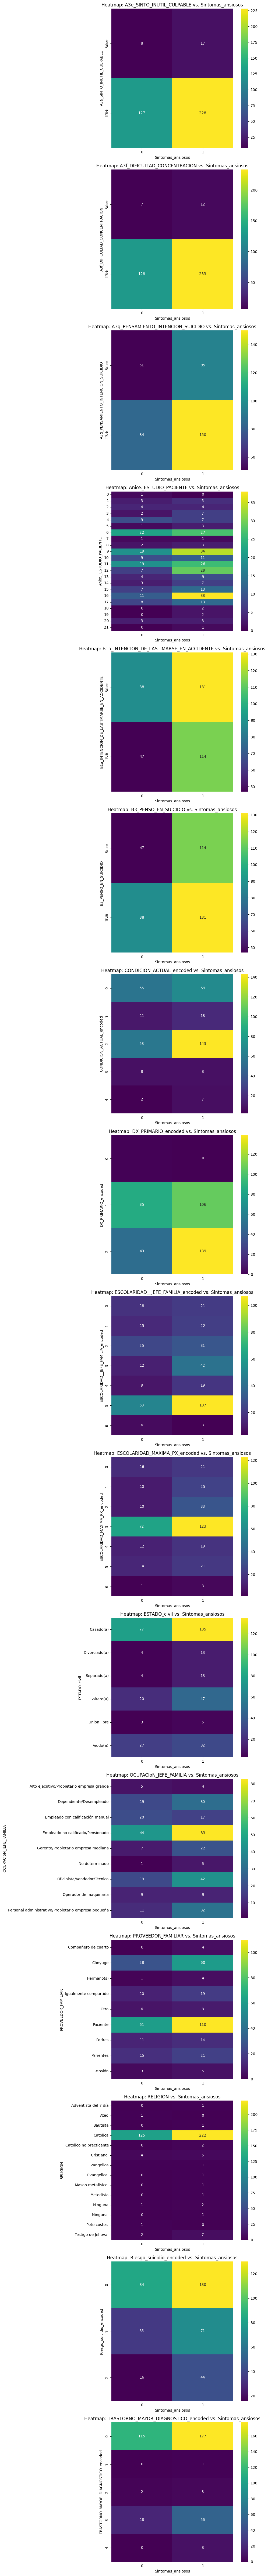

In [ ]:
variables = df_TC[["A3e_SINTO_INUTIL_CULPABLE", "A3f_DIFICULTAD_CONCENTRACION",
                     "A3g_PENSAMIENTO_INTENCION_SUICIDIO", "AnioS_ESTUDIO_PACIENTE",
                     "B1a_INTENCION_DE_LASTIMARSE_EN_ACCIDENTE", "B3_PENSO_EN_SUICIDIO",
                     "CONDICION_ACTUAL_encoded", "DX_PRIMARIO_encoded",
                     "ESCOLARIDAD__JEFE_FAMILIA_encoded", "ESCOLARIDAD_MAXIMA_PX_encoded",
                     "ESTADO_civil", "OCUPACIoN_JEFE_FAMILIA", "PROVEEDOR_FAMILIAR",
                     "RELIGION", "Riesgo_suicidio_encoded", "TRASTORNO_MAYOR_DIAGNOSTICO_encoded","Sintomas_ansiosos_encoded"]].columns[:-1]

# Crea una nueva figura para mostrar los heatmaps
plt.figure(figsize=(10, 6 * len(variables)))

# Itera sobre cada variable categórica y crea un heatmap
for i, variable in enumerate(variables):
    tabla_contingencia = pd.crosstab(df_TC[variable], df_TC['Sintomas_ansiosos_encoded'])
    plt.subplot(len(variables), 1, i + 1)
    sns.heatmap(tabla_contingencia, cmap='viridis', annot=True, fmt='d')
    plt.title(f'Heatmap: {variable} vs. Sintomas_ansiosos')
    plt.xlabel('Sintomas_ansiosos')
    plt.ylabel(variable)

# Ajusta el espacio entre los heatmaps
plt.tight_layout()

# Muestra los heatmaps uno debajo del otro
plt.show()